# PRMT-2427 Filter transfers that take longer than 24 hours out of the practice/CCG view

## Context

After running an investigation on a practice that challenged our data, we found that we are including transfers that take a long time within our transferred late table on the dashboard. The majority of transfers will be ready to integrate within 24 hours however some take longer. We want to filter out those transfers that take longer than 24 hours as it is unfair to display these on the dashboard under transferred late since the practice is not responsible for these being late.

# Scope
Investigate what proportion of transfers have duplicate EHRs sent beyond 24 hours from the start of the transfer 

comparison nationally of ‘old’ outcomes vs. ‘new outcomes’ (with this new column)

This is to identify how many transfers we might miss-categorise as slow and therefore not categorise as successful 

Provide a breakdown of transfers where data is sent after 24 hours using existing categorisation

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

# Show all columns
pd.set_option('display.max_columns', None)

In [2]:
transfer_file_location = "s3://prm-gp2gp-transfer-data-preprod/v5/"
transfer_files = [
    "2021/7/2021-7-transfers.parquet"
]
transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers_raw = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))

In [3]:
transfers = transfers_raw.copy()
transfers["status"] = transfers["status"].str.replace("_", " ").str.title()
transfers.shape

(227805, 14)

In [4]:
transfers["status"].value_counts()

Integrated On Time      196642
Process Failure          19745
Technical Failure        10881
Unclassified Failure       537
Name: status, dtype: int64

# Set-up

In [5]:
def bucket(duration):
    if duration < timedelta(days=1):
        return "<1 day"
    elif duration < timedelta(days=3):
        return ">= 1 day and < 3 days"
    elif duration < timedelta(days=5):
        return ">= 3 days and < 5 days"
    elif duration < timedelta(days=8):
        return ">= 5 days and < 8 days"
    else:
        return ">= 8 days and < 14 days"
    
def twenty_four_hour_bucket(duration):
    if duration < timedelta(days=1):
        return "<1 day"
    else:
        return ">= 1 day"

In [6]:
def bucket_transfer_duration_counts(filtered_transfers, bucketing_func):
    filtered_transfers_ehr_transfer_durations_bucketed = filtered_transfers.apply(bucketing_func)
    bucketed_filtered_transfers_counts = filtered_transfers_ehr_transfer_durations_bucketed.value_counts().to_frame("transfer_count").sort_index()
    bucketed_filtered_transfers_counts["transfer_percentage"] = (bucketed_filtered_transfers_counts / bucketed_filtered_transfers_counts["transfer_count"].sum()) * 100
    return bucketed_filtered_transfers_counts

In [7]:
# Create column to calculate ehr transfer time duration
transfers["time_until_ready_to_integrate"] = transfers["last_sender_message_timestamp"] - transfers["date_requested"]
transfers["time_until_ready_to_integrate"].value_counts()

0 days 00:00:05.706000    20
0 days 00:00:12.839000    19
0 days 00:00:07.548000    18
0 days 00:00:07.793000    18
0 days 00:00:09.719000    17
                          ..
7 days 08:43:47.307000     1
0 days 00:02:48.726000     1
0 days 02:29:40.134000     1
0 days 00:31:14.397000     1
0 days 00:06:46.271000     1
Name: time_until_ready_to_integrate, Length: 123480, dtype: int64

In [8]:
transfers["buckets"] = transfers["time_until_ready_to_integrate"].apply(bucket)

# Check transfers that take longer than 24 hours

In [9]:
# Filter for records that are ready for integration or have already been integrated
is_integrated = transfers["status"] == "Integrated On Time"
is_process_failure = transfers["status"] == "Process Failure"
transfered_transfers = transfers[is_integrated | is_process_failure].copy()
transfered_transfers_ehr_transfer_durations = transfered_transfers["time_until_ready_to_integrate"]
transfered_transfers_ehr_transfer_durations.describe()

count                       216387
mean     0 days 03:36:13.520423158
std      1 days 00:07:16.265491496
min         0 days 00:00:01.604000
25%         0 days 00:00:12.139500
50%         0 days 00:00:28.981000
75%         0 days 00:02:44.538000
max        13 days 23:57:20.824000
Name: time_until_ready_to_integrate, dtype: object

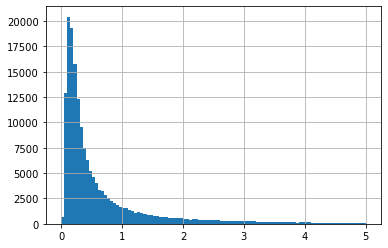

In [10]:
# Distrubution of ehr transfers times 
(transfered_transfers_ehr_transfer_durations/ pd.Timedelta(minutes=1)).hist(bins=100, range=[0,5])
plt.show()

In [26]:
bucket_transfer_duration_counts(transfered_transfers_ehr_transfer_durations, bucket)

,transfer_count,transfer_percentage
<1 day,210687,97.365831
>= 1 day and < 3 days,1406,0.649762
>= 3 days and < 5 days,1537,0.710301
>= 5 days and < 8 days,1458,0.673793
>= 8 days and < 14 days,1299,0.600313


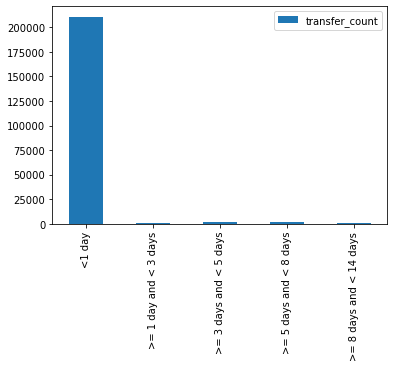

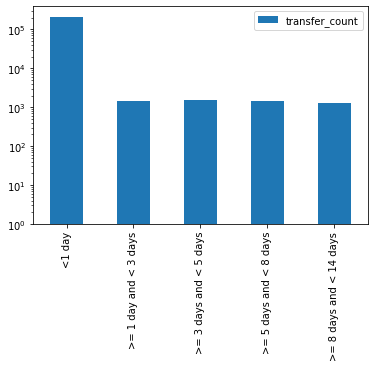

In [13]:
bucketed_sender_delta_counts.plot.bar()
plt.show()
bucketed_sender_delta_counts.plot.bar(log=True)
plt.show()

In [14]:
# Transferred transfers (integrated ontime, integrated late, ready to integrate) - transfer duration beyond 24 hours
bucket_transfer_duration_counts(transfered_transfers_ehr_transfer_durations, twenty_four_hour_bucket)

,transfer_count,transfer_percentage
<1 day,210687,97.365831
>= 1 day,5700,2.634169


# Check transfers that took longer than 24 hours & integrated ontime

In [15]:
# Filter for records that took longer than 24 hours and integrated ontime
is_integrated = transfers["status"] == "Integrated On Time"
integrated_ontime_transfers = transfers[is_integrated].copy()

integrated_ontime_transfers_ehr_transfer_durations = integrated_ontime_transfers["time_until_ready_to_integrate"]
integrated_ontime_transfers_ehr_transfer_durations.count()

196642

In [16]:
# Integrated on time - transfer duration breakdown in days
bucket_transfer_duration_counts(integrated_ontime_transfers_ehr_transfer_durations, bucket)

,transfer_count,transfer_percentage
<1 day,193039,98.167736
>= 1 day and < 3 days,1215,0.617874
>= 3 days and < 5 days,1230,0.625502
>= 5 days and < 8 days,855,0.434800
>= 8 days and < 14 days,303,0.154087


In [17]:
# Integrated on time - transfer duration beyond 24 hours
bucket_transfer_duration_counts(integrated_ontime_transfers_ehr_transfer_durations, twenty_four_hour_bucket)

,transfer_count,transfer_percentage
<1 day,193039,98.167736
>= 1 day,3603,1.832264


In [18]:
is_more_than_8_days = transfers["buckets"] == ">= 8 days and < 14 days"
# integrated_ontime_transfers[is_more_than_8_days].head(2)

# Check transfers that took longer than 24 hours & integrated late (process failure)

In [19]:
# Filter for records that took longer than 24 hours and integrated late
is_integrated_late = transfers["failure_reason"] == "Integrated late"
integrated_late_transfers = transfers[is_integrated_late].copy()
integrated_late_transfers_ehr_transfer_durations = integrated_late_transfers["time_until_ready_to_integrate"]
integrated_late_transfers_ehr_transfer_durations.count()

9153

In [20]:
# Integrated late - transfer duration breakdown in days
bucket_transfer_duration_counts(integrated_late_transfers_ehr_transfer_durations, bucket)

,transfer_count,transfer_percentage
<1 day,7948,86.834918
>= 1 day and < 3 days,104,1.136239
>= 3 days and < 5 days,144,1.573255
>= 5 days and < 8 days,409,4.468480
>= 8 days and < 14 days,548,5.987108


In [ ]:
# Integrated late - transfer duration beyond 24 hours
bucket_transfer_duration_counts(integrated_late_transfers_ehr_transfer_durations, twenty_four_hour_bucket)

# Check transfers that took longer than 24 hours & not integrated (process failure)

In [22]:
# Filter for records that took longer than 24 hours and didn't integrated
is_transferred_not_integrated = transfers["failure_reason"] == "Transferred, not integrated"
transferred_not_integrated_transfers = transfers[is_transferred_not_integrated].copy()
transferred_not_integrated_transfers_ehr_transfer_durations = transferred_not_integrated_transfers["time_until_ready_to_integrate"]
transferred_not_integrated_transfers_ehr_transfer_durations.count()

10592

In [23]:
# Transferred not integrated - transfer duration breakdown in days
bucket_transfer_duration_counts(transferred_not_integrated_transfers_ehr_transfer_durations, bucket)

,transfer_count,transfer_percentage
<1 day,9700,91.578550
>= 1 day and < 3 days,87,0.821375
>= 3 days and < 5 days,163,1.538897
>= 5 days and < 8 days,194,1.831571
>= 8 days and < 14 days,448,4.229607


In [24]:
# Transferred not integrated - transfer duration beyond 24 hours
bucket_transfer_duration_counts(transferred_not_integrated_transfers_ehr_transfer_durations, twenty_four_hour_bucket)

,transfer_count,transfer_percentage
<1 day,9700,91.57855
>= 1 day,892,8.42145
